In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [3]:

def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [4]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [5]:
df = pd.read_csv('train.csv')

In [8]:
df.head(1)

,ID,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,target
0,1,0.13537,0.45185,0.31162,2.0469,10.234,0.16768,0.16763,1.2131,2.2554,...,0.078728,0.24695,0.92586,0.18362,9.0895,8.8342,48.172,7.577,5.7725,0


In [10]:
X = df.loc[:, df.columns!='target']
Y = df.loc[:, df.columns=='target']


In [14]:

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify=Y)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

In [17]:
X_tr.fillna(X_tr.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
X_cv.fillna(X_cv.mean(), inplace=True)


In [19]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=True)
Xbow_tr_std = sc.fit_transform(X_tr)
Xbow_test_std = sc.transform(X_test)
Xbow_cv_std = sc.transform(X_cv)

In [20]:

clf = LogisticRegression().fit(Xbow_tr_std, y_tr)

In [25]:
Y_Test_Pred = clf.predict(Xbow_test_std)

In [26]:
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test['target'], name = 'Actual'))

Actual,0,1
Predicted,,
0,1397,70
1,1547,81


In [28]:

generate_model_report(y_test, Y_Test_Pred)

Accuracy =  0.4903569525839105
Precision =  0.05598851517637408
Recall =  0.6026490066225165
F1 Score =  0.10245824732595234


In [34]:

unique_classes = list(df['target'].unique())
unique_classes

[0, 1]

In [36]:
out_dict = {}
for classes in unique_classes:
    out_dict[classes] = df.shape[0]/((df.loc[df['target'] == classes].shape[0])
                                     *len(unique_classes))

In [37]:
out_dict

{0: 0.5253761923955395, 1: 10.351753805426869}

In [38]:
print (Xbow_tr_std.shape, y_tr.shape)

(15328, 65) (15328, 1)


In [40]:
clf = LogisticRegression(class_weight='balanced').fit(Xbow_tr_std, y_tr)

In [41]:
from sklearn.utils import class_weight

In [42]:

class_weight.compute_class_weight('balanced', np.unique(y_tr), y_tr['target'])

array([ 0.52586798, 10.16445623])

In [43]:
Y_Test_Pred = clf.predict(Xbow_test_std)

In [45]:
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test['target'], name = 'Actual'))

Actual,0,1
Predicted,,
0,1986,109
1,958,42


In [46]:
generate_model_report(y_test, Y_Test_Pred)

Accuracy =  0.6953649440596696
Precision =  0.09603760913364674
Recall =  0.6313465783664459
F1 Score =  0.1667152433692801


In [49]:
weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc.fit(X_tr, y_tr)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.05, 1: 0.95}}


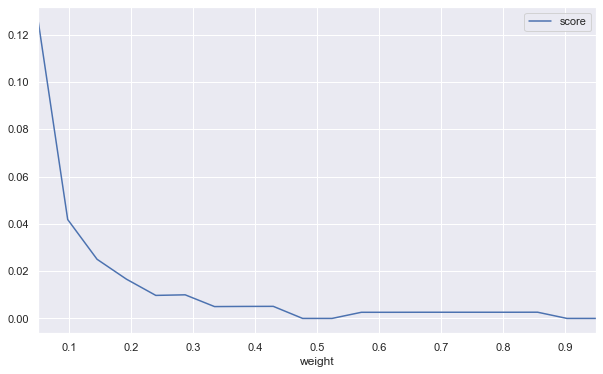

In [50]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [52]:
clf = LogisticRegression(**grid_result.best_params_).fit(X_tr, y_tr)

In [53]:
Y_Test_Pred = clf.predict(X_test)

In [55]:
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(Y_test['target'], name = 'Actual'))

Actual,0,1
Predicted,,
0,1538,79
1,1406,72


In [57]:
generate_model_report(y_test, Y_Test_Pred)

Accuracy =  0.5485348961108152
Precision =  0.06843065693430657
Recall =  0.6622516556291391
F1 Score =  0.12404382881951623
